#  Lecture 3a MCMC

# Introduction

In this notebook we will discuss the following algorithms for estimating the posterior distribution:
- Monte Carlo based algorithms




## Monte Carlo Importance sampling

Assume that you want samples from a Gamma distribution $\textsf{Gamma}\left(\lambda|\alpha_0,\beta_0 \right)$

a) In order to generate (weighted) samples from p(x), implement an importance sampler with a standard normal
distribution (mean = 1, variance = 1) as proposal. Draw L = 1 000 samples.

b) To inspect your obtained Monte Carlo approximation, plot a histogram of the samples (note that you have to take the
weights into account!) together with the target pdf and the proposal pdf. What can you say about the quality of the
approximation you have obtained? How does it relate to the shape of the proposal?

c) Try using more samples L. Does the Monte Carlo approximation improve?

d) Limit yourself to L = 1 000 samples again, and try to instead adjust the proposal to improve the approximation.

e) Use the samples to estimate the mean and variance of the target. (One can analytically show that the mean is 􀀀1:41
and the variance 1:98). Explore how the quality of these estimates changes with different L.

f) Change the proposal to a uniform distribution on the interval [􀀀4; 1]. Is it still a valid importance sampler?

In [1]:
using Distributions
using Turing
using StatisticalRethinking
using Random, Plots, MCMCChains

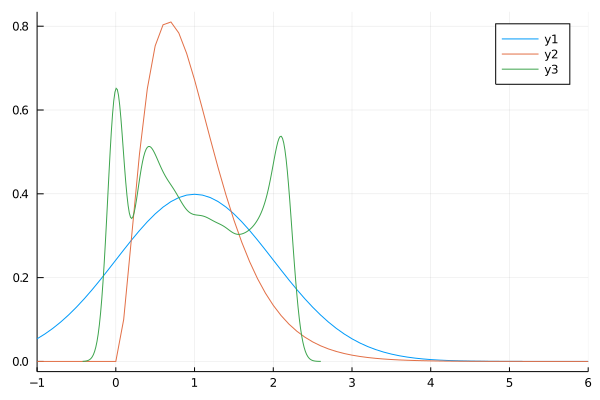

In [62]:
xGrid = -1:0.1:6
pdfnormalDensity(z) = pdf(Normal(1,1),z)
pdf_normal=pdfnormalDensity.(xGrid)
plot(xGrid,pdf_normal)
pdfGamaDensity(z)=pdf(Gamma(3, 1/3), z)
pdf_Gama=pdfGamaDensity.(xGrid)
plot!(xGrid,pdf_Gama)
x=rand(Normal(1,1),10000)
p1(z)=pdf(Gamma(3, 1/3), z)
q1(z)=pdf(Normal(1,1),z)
w= p1.(x)./q1.(x)
#histogram!(w, bins=100, xlims=(-1,6), c=:black, normed=true, label="Histogram of IS")
density!(w, xlims=(-1,6))

In [63]:
mean(rand(Gamma(3, 1/3), 1000))-mean(w)

0.006033663343095297

## Markov chain

#### Example
Let’s make a simulation of a chain w/ two different starting
points; one change starting at 100 and another at -27.
• The step to X(t+1) from X(t) is governed by a random number drawn
from a normalized gaussian PDF  that is
dependent on X(t):

$x(t+1)=0.9*x(t)+v(k)$ and $v(k)\sim \mathcal{N}(0, 0.19)$



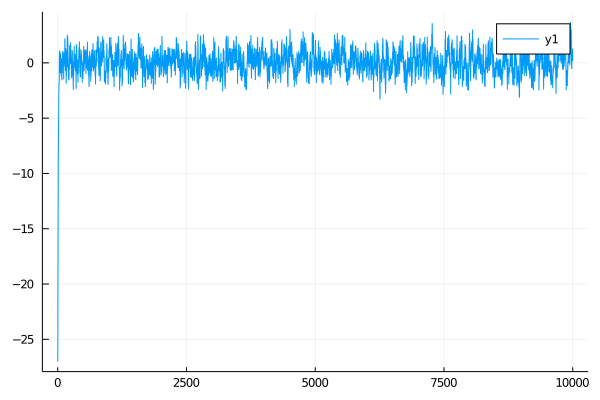

In [83]:
N=10000
x=Vector{Real}(undef, N)
x[1]=-27
for j in 2:N
   x[j]=0.9*x[j-1]+rand(Normal(0,sqrt(0.19)))
end
plot(x)


In [89]:
var(x[5000:end])

1.0068738652733602

Mean and the variance are $E(x(t))=0$ and $var(x(t))=1$

#### Example 
What is p(x(t+2)=3|p(x(t)=1)?

In [97]:
using LinearAlgebra, Statistics, StatsBase, Plots; 

n, N = 5, 10^6
Q= [0 0.5 0 0 0.5;
    0.5 0 0.5 0 0;
    0 0.5 0 0.5 0;
    0 0 0.5 0 0.5;
    0.5 0 0 0.5 0]

Q2=Q*Q
Q2[1,3]

0.25

What is p(x(t+h)=3|p(x(t)=1) where h=30?


In [98]:
Q30=Q
for i in 2:30
    Q30=Q30*Q
end
Q30

5×5 Array{Float64,2}:
 0.200693  0.199439  0.200214  0.200214  0.199439
 0.199439  0.200693  0.199439  0.200214  0.200214
 0.200214  0.199439  0.200693  0.199439  0.200214
 0.200214  0.200214  0.199439  0.200693  0.199439
 0.199439  0.200214  0.200214  0.199439  0.200693

If we let h be very large, then the stationary distribution has all values 0.2 meaning that there is an equal probability to be in any state.


## Metropolis Hastings

This example is from the book Statistics with Julia. Proposal distribution q is given as:
$$ \mathcal{N}(x\,;\,\mu,\sigma)=\, \frac{1}{\sigma (2\pi)^{\frac{1}{2}}} \{exp\big[ -\frac{(x-\mu)}{2\sigma^2}\big]^2 + exp\big[ -\frac{(x+\mu)}{2\sigma^2}\big]^2\}$$

MCMC Bayes Estimate: 2.064242708023352


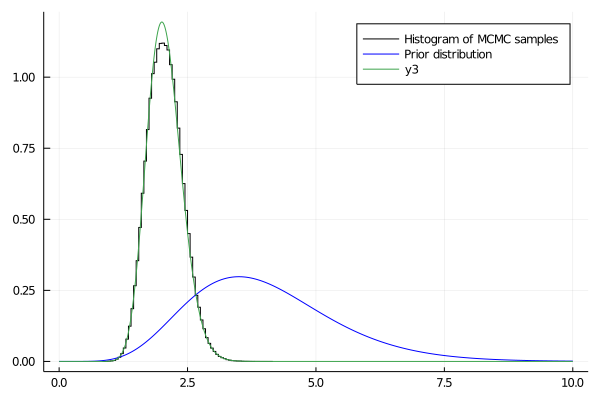

In [100]:
using Distributions, Plots

alpha, beta = 8, 2
prior(lam) = pdf(Gamma(alpha, 1/beta), lam)
data = [2,1,0,0,1,0,2,2,5,2,4,0,3,2,5,0]

like(lam) = *([pdf(Poisson(lam),x) for x in data]...)
posteriorUpToK(lam) = like(lam)*prior(lam)

sig = 0.5
foldedNormalPDF(x,mu) = (1/sqrt(2*pi*sig^2))*(exp(-(x-mu)^2/2sig^2) + exp(-(x+mu)^2/2sig^2))
foldedNormalRV(mu) = abs(rand(Normal(mu,sig)))

function sampler(piProb,qProp,rvProp)
    lam = 1
    warmN, N = 10^5, 10^6
    samples = zeros(N-warmN)

    for t in 1:N
        while true
            lamTry = rvProp(lam)
            L = piProb(lamTry)/piProb(lam)
            H = min(1,L*qProp(lam,lamTry)/qProp(lamTry,lam))
            if rand() < H
                lam = lamTry
                if t > warmN
                    samples[t-warmN] = lam
                end
                break
            end
        end
    end
    return samples
end

mcmcSamples = sampler(posteriorUpToK,foldedNormalPDF,foldedNormalRV)
println("MCMC Bayes Estimate: ",mean(mcmcSamples))

stephist(mcmcSamples, bins=100, c=:black, normed=true, label="Histogram of MCMC samples")

lamRange = 0:0.01:10
plot!(lamRange, prior.(lamRange), c=:blue, label="Prior distribution")

closedFormPosterior(lam)=pdf(Gamma(alpha + sum(data),1/(beta+length(data))),lam)
plot!(lamRange, closedFormPosterior.(lamRange))#, c=:red, label="Posterior distribution", xlims=(0, 10), ylims=(0, 1.2), xlabel="\lambda",ylabel="Density")


## Gibbs sampling
Consider the bivariate normal
model
$$(x,y)\sim \mathcal{N}(0 , \begin{bmatrix}1&\rho\\\rho&1\end{bmatrix})$$
Then,
$$y_{t+1}|x_t\sim \mathcal{N}(\rho\cdot x_t , 1-\rho^2)$$
$$x_{t+1}|y_{t+1}\sim \mathcal{N}(\rho\cdot y_{t+1} , 1-\rho^2)$$

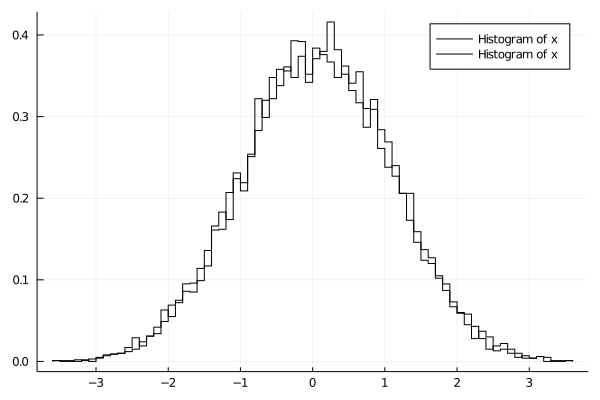

In [102]:
function bigibbs(T, rho)
    x = ones(T+1)
    y = ones(T+1)
    for t = 1:T
        x[t+1] = randn() * sqrt(1-rho^2) + rho*y[t]
        y[t+1] = randn() * sqrt(1-rho^2) + rho*x[t+1]
    end
    return x, y
end

## example
x,y=bigibbs(10000, 0.95)
stephist(x, bins=100, c=:black, normed=true, label="Histogram of x")
stephist!(y, bins=100, c=:black, normed=true, label="Histogram of y")


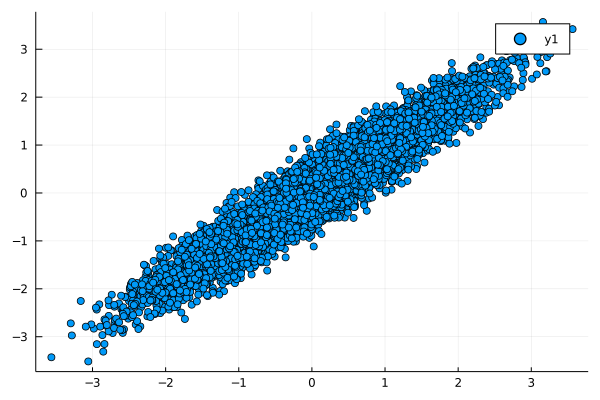

In [103]:
plot(x,y,seriestype = :scatter)

Gibbs is used like this in modern tools like Turing:
Example:


@model gibbs_example(x) = begin
    v1 ~ Normal(0,1)
    v2 ~ Categorical(5)
end
Use PG for a ‘v2’ variable, and use HMC for the ‘v1’ variable. Note that v2 is discrete, so the PG sampler is more appropriate than is HMC.

alg = Gibbs(HMC(0.2, 3, :v1), PG(20, :v2)) 

## Diagnostics
Let us look again the simple problem of success rate from the first lecture. We will go through the slides [Convergence Diagnostics For Markov chain Monte Carlo Eric B. Ford (Penn State)](https://astrostatistics.psu.edu/RLectures/diagnosticsMCMC.pdf)


In [105]:
k=90;
n=100;
α=1
β=1
##
@model infer_rate(k,n) = begin
    # Our prior belief about the probability of heads in a coin.
    θ ~ Beta(α, β)
    # Heads or tails of a coin are drawn from a Bernoulli distribution.
    k ~ Binomial(n, θ)
end;

In [146]:
# Sampling from the model and indering the posterior distribution
#chain = sample(infer_rate(k,n), HMC(0.05, 10), 2000);
# Try MH(), HMC(0.05, 10)
chain=mapreduce(c -> sample(infer_rate(k,n),  MH(), 1500),
    chainscat,
    1:3
);

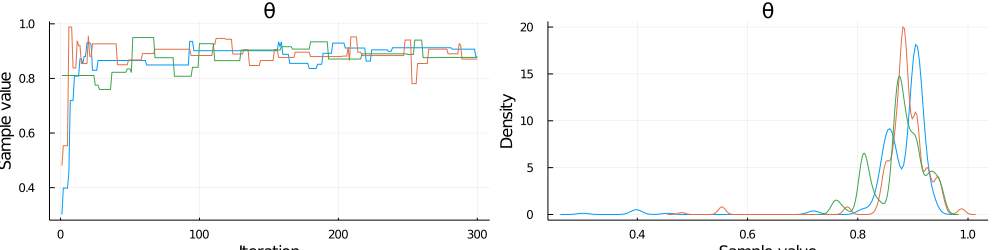

In [147]:
plot(chain)

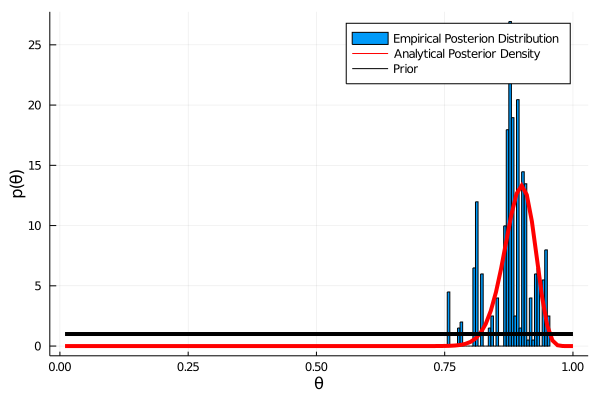

In [148]:
#Draw posterior distribution
burnin=500
p_summary = chain[:θ][burnin:end]
histogram(p_summary, xlabel="θ", bins=40, normed=true, label="Empirical Posterion Distribution")
xGrid = 0.01:0.01:1
dist=Beta.(k+α,n-k+β) 
dist_prior=Beta.(α,β) 

plot!( xGrid, pdf.(dist,xGrid), c=:red, lw=4, xlabel="θ", label="Analytical Posterior Density", ylabel = "p(θ)", legend=:topright)
plot!( xGrid, pdf.(dist_prior,xGrid), c=:black, lw=4, xlabel="θ", label="Prior", ylabel = "p(θ)", legend=:topright)


#### Autocorrelation function (ACF) 
Highly correlated MCMC samplers requires more samples to produce the same level of Monte Carlo error for an estimate. The autocorrelation function is defined as
$$\rho(l)=corr[\theta_0, \theta_l]$$ 
where $l$ is called the lag. The ACF can be computed efficiently by convolving the signal x with itself. If we plot ACF for MH and for HMC samplers we see that HMC samples are much less correlated than MH samples. 
Intuitively this indicates that each HMC sample is worth more than each MH sample.

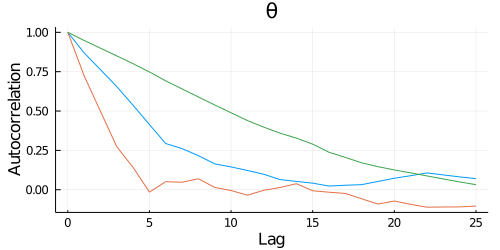

In [149]:
autocorplot(chain)

**Gelman-Rubin** diagnostic $\hat{r}$ should be <1.001.

**MC error** is defined as $\sigma(\theta)/\sqrt(n)$ and it is presented as mcse.

**Effective sample size (ess)** represents the number of useful uncorelated samples in the chain. We quantify this below. Let us define autocorrelation time as  $\rho=1+2\sum_{l=1}^{\infty}\rho(l)$. 
The effective sample size is defined as the number of samples divided by the autocorrelation time:
$$N_{eff}=\frac{N}{\rho}=\frac{N}{1+2\sum_{l=1}^{\infty}\rho(l)}$$
If we truncate the sum at lag $L$ and if we run $J$ chains then the effective sample size is:
$$\hat{N}_{eff}=\frac{NJ}{\rho}=\frac{N}{1+2\sum_{l=1}^{L}\rho(l)}$$

For MH sampler, the ess=442 while for HMC is 4327.


In [150]:
display(chain)

Chains MCMC chain (300×2×3 Array{Float64,3}):

Iterations        = 1:300
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 300
parameters        = θ
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat 
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64 

           θ    0.8790    0.0603     0.0020    0.0087   51.8170    1.0446

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           θ    0.7672    0.8658    0.8876    0.9071    0.9497


**Gelman Rubin statistics (rhat)**
If we were to start multiple parallel chains, then they should all eventually converge to the stationary distribution. So after some amount of time, it should be impossible to distinguish between the multiple chains.  One way to assess this is to compare the variation between chains to the variation within the chains. We expect that the between chain variation should be close to zero.

Let $x_1^{(j)}, x_2^{(j)},\dots$ be samples from the jth Markov chain and suppose there are J chains run in parallel with different starting values. For each chain, first discard  
D   values as “burn-in” and keep the remaining L values,  

Calculate:

\begin{eqnarray*}
\bar{x}_j 
& = &
\frac{1}{L}\sum_{t=1}^L x_t^{(j)}\hspace{2em}\text{(chain mean)}\\
\bar{x}_\cdot 
& = &
\frac{1}{J}\sum_{j=1}^J \bar{x}_j\hspace{2em}\text{(grand mean)}\\
B
& = &
\frac{L}{J=1}
\sum_{j=1}^J (\bar{x}_j-\bar{x}_\cdot)^2\hspace{2em}\text{(between chain variance)}\\
s^2_j
& = &
\frac{1}{L-1}
\sum_{t=1}^L (x_t^{(j)}-\bar{x}_j)^2\hspace{2em}\text{(within chain variance)}\\
W 
& = &
\frac{1}{J}\sum_{j=1}^J s_j^2
\end{eqnarray*}

Gelman Rubin statistics is then calculated as:
$$R = \frac{
\frac{L-1}{L}W + \frac{1}{L}B
}{W}$$

In [151]:
gelmandiag(chain)

Gelman, Rubin, and Brooks Diagnostic
  parameters      psrf     97.5% 
      Symbol   Float64   Float64 

           θ    1.0507    1.0685


## Stochastic Gradient Langevin Dynamics
We will rely on [Bayesian inference with Stochastic Gradient Langevin Dynamics](https://sebastiancallh.github.io/post/langevin/) by Sebastian Callh.
